In [1]:
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# analytics
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
# pyramid arima
import pmdarima as pm
from pmdarima import model_selection
# pickel best model
import joblib

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from base.logging import Logger

In [4]:
PROJECT = 'covid'
ENV = 'dev'
ID = f'{PROJECT}-{ENV}'

global log
log = Logger(ID)

In [10]:
from base.data import Data

In [11]:
data = Data()
data.extract()
data.transform()
data.load()

/Users/tjordan/Documents/github/covid19/base/data.py:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  self.df.index = pd.to_datetime(self.df.index)


In [14]:
class Forecast:
    def __init__(self,df,retrain):
        self.log = log
        self.df = df
        self.retrain = retrain
        
        self.periods_fc = 90
        self.main_strt_dt = datetime.datetime(2022,7,1)
        self.test_strt_dt = (self.main_strt_dt - datetime.timedelta(days=self.periods_fc))
        
        self.test_model = None
        self.main_model = None
        
        self.test_fc = None
        self.main_fc = None

        self.model_fname = f'{os.getcwd()}/arima.pkl'
    
    def run(self,run_type):        
        if run_type == 'test':
            train_df = self.df.loc[self.df.ds<=self.test_strt_dt]
        elif run_type == 'main':
            train_df = self.df.loc[self.df.ds<=self.main_strt_dt]
        
        if self.retrain:
            model = pm.auto_arima(train_df.y, error_action='ignore', trace=True,
                    suppress_warnings=True, maxiter=5,
                    seasonal=True, m=12
            )
            # save model
            # joblib.dump(arima, self.model_fname, compress=3)
            
        else:
            raise Exception('Not ready yet!')
            # load model
            # model = joblib.load(self.model_fname)
            
        future = self._make_future_dataframe(train_df.ds.max(),periods=self.periods_fc)
        # basic
        predictions = model.predict(n_periods=future.shape[0])
        
        # cross validation
        # tscv = TimeSeriesSplit(n_splits=5)
        # best_mse = float('inf')  # Initialize best_mse to a high value
        # predictions = None
        # for train_idx, test_idx in tscv.split(train_data):
        #     train_fold, test_fold = train_data.iloc[train_idx], train_data.iloc[test_idx]
        #     model.fit(train_fold)
        #     forecast, conf_int = model.predict(n_periods=90, return_conf_int=True)
        #     mse = mean_squared_error(test_data, forecast[:len(test_data)])
        #     if mse < best_mse:
        #         best_mse = mse
        #         predictions = forecast

        predictions = pd.Series(predictions.values,index=future.index).rename('yhat')
        pred_df = pd.concat([predictions,future],axis=1)
        setattr(self,f'{run_type}_fc',pred_df)
        setattr(self,f'{run_type}_model',model)

    def _make_future_dataframe(self,start_date,periods):
        return pd.DataFrame({
            'ds': pd.date_range(start_date, periods=periods, freq='D')
        })
    
    def compile(self):
        self.fc = pd.concat([
            self.df.loc[self.df.ds<=self.test_strt_dt],
            self.test_fc.merge(self.df,how='inner',on='ds'),
            self.main_fc
        ],axis=0)
    
    def graph(self):
        plt.style.use('fivethirtyeight') # ggplot, fivethirtyeight, tableau-colorblind10, grayscale

        fig, ax1 = plt.subplots(figsize=(12,6))
        fig.suptitle('Covid19 Time Series Forecast - Richmond, VA', fontsize=18) # fontweight='bold'
        fig.tight_layout()
        ax1.grid(True)

        ax1.plot(self.fc.ds,self.fc.y,color='#091d63',label='Y',linewidth=2)
        ax1.plot(self.fc.ds,self.fc.yhat,color='#630909',linestyle='--',label='Yhat',linewidth=2)
        ax1.set_xlabel('Date',fontsize=10)
        ax1.set_ylabel('Covid19 Cases',fontsize=10)
        ax1.legend(loc='upper left')
        
        ax1.xaxis.set_tick_params(rotation=45)
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
        plt.figtext(0,-0.2,f'Data up to {self.main_strt_dt.strftime("%Y-%m-%d")}',fontsize=10)

        pm.tsdisplay(self.df.y, lag_max=90, show=True)
        seasonal_decompose(self.df.set_index('ds').y, model='additive').plot()
        plt.show()
        display(self.main_model.summary())

In [15]:
# df = data.df.copy()
# df['y'] = df.y.diff()
# fc = Forecast(df, retrain=True)
fc = Forecast(data.df, retrain=True)

In [16]:
fc.run('test')
fc.run('main')
fc.compile()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/opt/anaconda3/lib/python3.9/site-packages/pmdarima/utils/visualization.py:220: FutureWarning: the 'unbiased' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


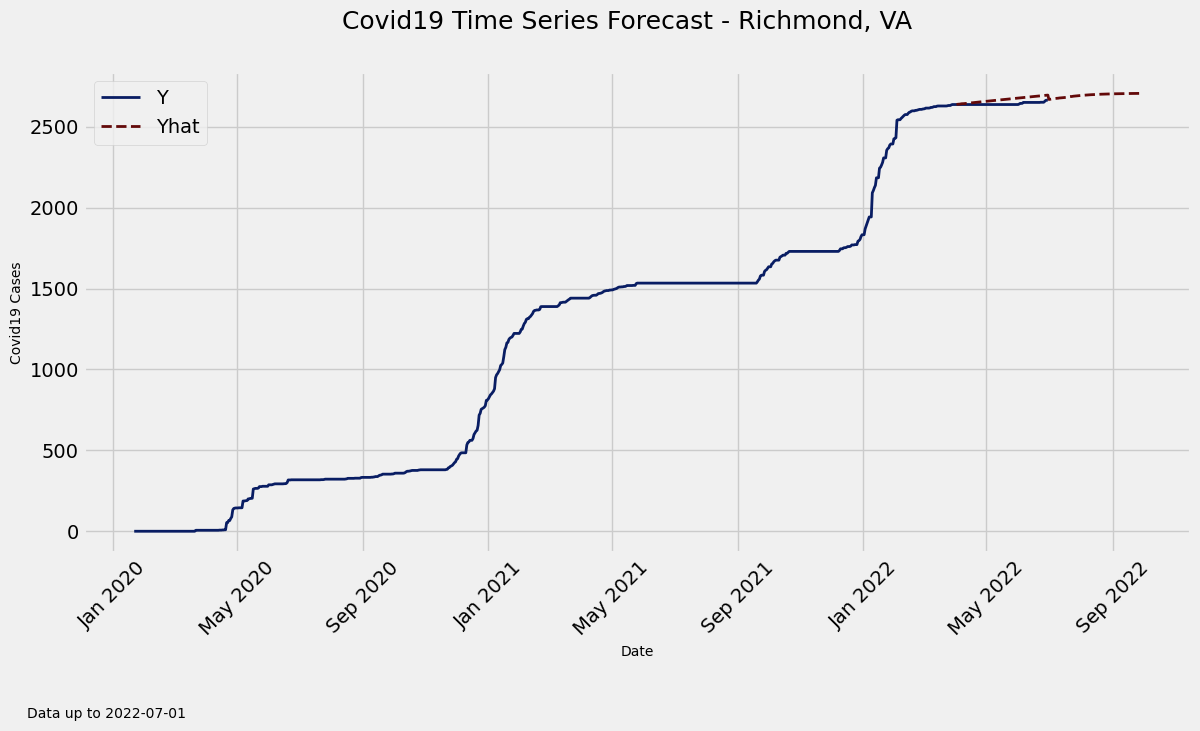

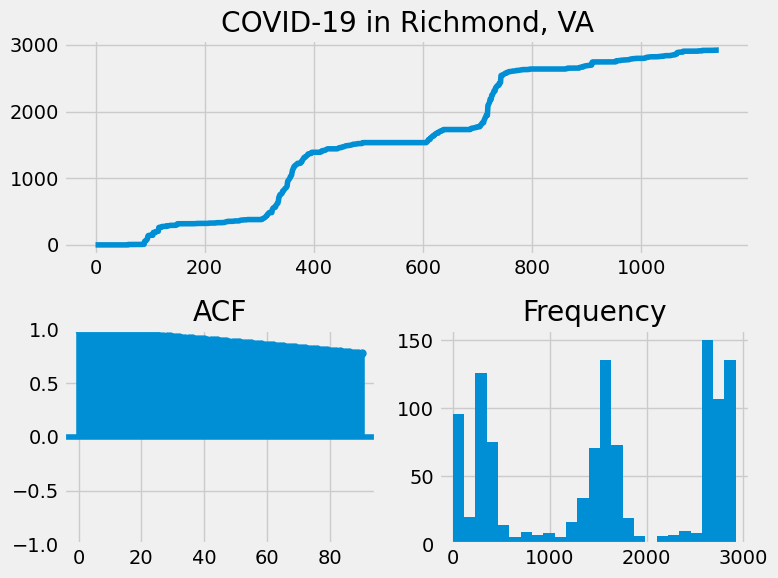

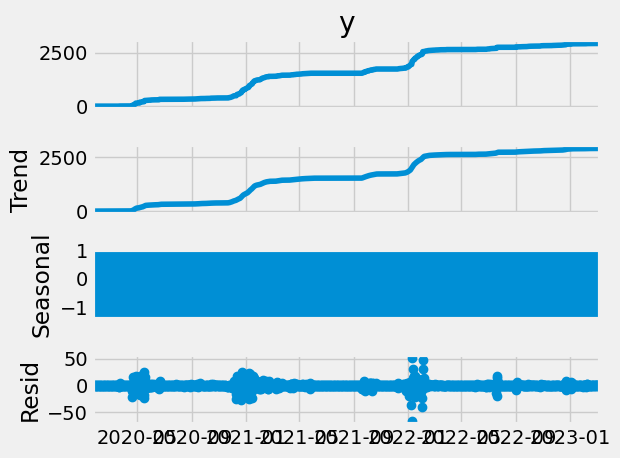

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  892
Model:             SARIMAX(5, 1, 2)x(1, 0, 2, 12)   Log Likelihood               -3149.366
Date:                            Thu, 12 Oct 2023   AIC                           6320.732
Time:                                    17:48:31   BIC                           6373.448
Sample:                                         0   HQIC                          6340.880
                                            - 892                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0834      0.157      0.530      0.596      -0.225       0.392
ar.L2          0.6397      0.155      4.139      0.000       0.337       0.943
ar.L3          0.0568      0.038      1.483      0.138      -0.018       0.132
ar.L4          0.0526      0.034      1.526      0.127      -0.015       0.120
ar.L5          0.0779      0.034      2.263      0.024       0.010       0.145
ma.L1         -0.0362      0.158     -0.229      0.819      -0.346       0.274
ma.L2         -0.6047      0.147     -4.120      0.000      -0.892      -0.317
ar.S.L12       0.0462      0.161      0.287      0.774      -0.269       0.362
ma.S.L12      -0.1502      0.152     -0.990      0.322      -0.448       0.147
ma.S.L24       0.2994      0.019     15.623      0.000       0.262       0.337
sigma2        72.1592      0.865     83.416      0.000      70.464      73.855
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):            364762.69
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               3.35   Skew:                             7.40
Prob(H) (two-sided):                  0.00   Kurtosis:                       101.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
fc.graph()